## **Fichier dédié à l'établissement du modèle de régression linéaire**

Ligne de commande pour lancer le notebook depuis le terminal. Soit à coupler avec nohup ou une session tmux pour le laisser tourner en arrière plan
```bash
jupyter nbconvert --to notebook --execute --inplace regression_MLP.ipynb
```

### **Importation des modules**

In [2]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import LeaveOneOut, train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.stats import pearsonr,loguniform
import qsar_utils as qu
import pickle
import os
import re
import ast

### **Importation des données**

In [2]:
df_norm = pd.read_csv("data/qsar_fish_toxicity_norm.csv")
data = df_norm.drop(columns=["LC50"])
LC50 = df_norm["LC50"]

### **Mise au point du modèle**

Le but du modèle de régression basé sur des réseaux neuronaux et d'observer si nous arrivons à obtenir de meilleur résultats qu'avec la méthode de RandomForest qui est souvent l'une des plus performantes dans le contexte des modèles QSAR.

**Hyperparamètres à évaluer** :
- Nombre total de neurones
- Nombre de couches cachées
- Courbe d'apprentissage
- Type d'activation
- Nombre d'itérations pour la convergence

### Modèle simple : Première approche

In [3]:
def LOO_LC50(df : pd.DataFrame, df_LC50 : pd.DataFrame) -> tuple[list[float], float]:
    """
    Cette fonction permet d'effectuer un Leave one Out sur des données pandas et de l'appliquer à un perceptron multicouche pour
    prédire la valeur de la LC50 d'une molécule
    df : tableau pandas avec les données
    df_LC50 : tableau pandas avec les valeurs de la LC50
    """
    loo = LeaveOneOut() # initialisation du LeaveOneOut
    predicted_LC50 = list()
    model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=0, verbose = True)
    cpt = 0
    tot = len(df)
    for train_index, test_index in loo.split(df): # parcours des index sélectionnés par le leave one out
        model.fit(df.iloc[train_index], df_LC50.iloc[train_index])
        predict = model.predict(df.iloc[test_index])
        predicted_LC50.append(predict[0])
        print(f"{cpt}/{tot}", end="\r") # affiche la progression sans surcharger la console
        cpt += 1
    print(f"{cpt}/{tot}") # reset de l'affichage
    corr_coef, _ = pearsonr(df_LC50, predicted_LC50) # calcul du coefficients de corrélation
    return predicted_LC50, corr_coef

In [ ]:
predicted_LC50, corr_coef = LOO_LC50(data, LC50)
with open("data/models/predicted_LC50_MLP_basic_100_100.pkl", "wb") as f:
    pickle.dump(predicted_LC50, f)

/home/be203133/.conda/envs/projet_ia/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


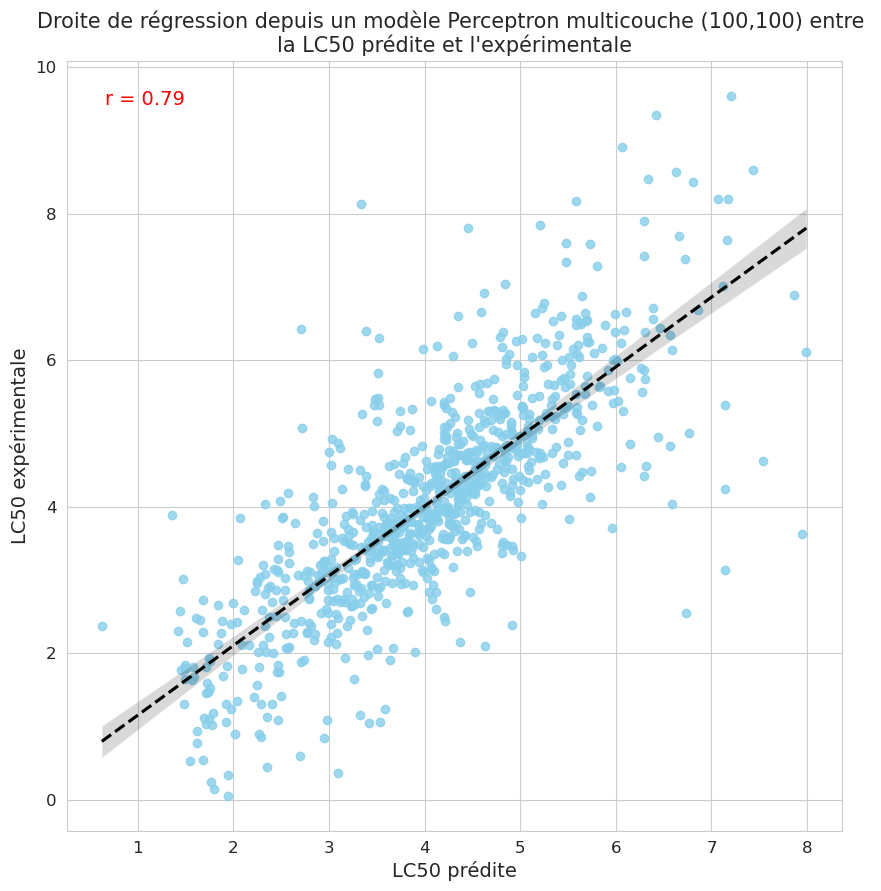

In [7]:
qu.scatter_QSAR(x_data = predicted_LC50, 
                y_data = LC50, 
                model_type = "Perceptron multicouche (100,100)",  
                corr_coef = corr_coef)

### Définition du domaine d'applicabilité (AD)
- ###  AD simple par ACP

#### Mise au point des données

Le choix est d'enlever la LC50 pour ne pas biaiser la création de l'ACP et la validation des données de test

In [3]:
train_data, test_data = train_test_split(df_norm, test_size=0.2, random_state=0)
train_data_LC50 = train_data["LC50"]
test_data_LC50 = test_data["LC50"]
train_data = train_data.drop(columns=["LC50"])
test_data = test_data.drop(columns=["LC50"])

#### Mise au point de l'ACP pour la définition du domaine d'application

In [4]:
pca = PCA(n_components=3)
data_train_pca = pca.fit_transform(train_data)
data_test_pca = pca.transform(test_data)

# Variance expliquée par composante
variance_expliquee = pca.explained_variance_ratio_
print("Variance expliquée par composante :", variance_expliquee)
print("Variance expliquée cumulée :", variance_expliquee.cumsum())

Variance expliquée par composante : [0.65497285 0.25594809 0.03844262]
Variance expliquée cumulée : [0.65497285 0.91092093 0.94936356]


On est à environ 95% de la variance expliquée avec les 3 premières CP donc on va se baser dessus pour le domaine d'applicabilité

#### Déinition des bornes du domaine

In [5]:
def in_bounding_box(sample_pca : np.ndarray, pca_min : float, pca_max : float) -> bool:
    """
    Fonction pour décider si un échantillon est dans une boîte bornée par des valeurs min et max de ses composantes PCA
    sample_pca : vecteur des composantes [comp1, comp2, ...]
    pca_min, pca_max : bornes min et max par composante (shape = [n_components])
    """
    return np.all(sample_pca >= pca_min) and np.all(sample_pca <= pca_max)

In [6]:
pca_min = np.min(data_train_pca, axis=0)
pca_max = np.max(data_train_pca, axis=0)

#### Sélection des données de tests comprises dans l'AD 
C'est le moyen le plus rapide mais aussi le plus grossier pour sélectionner les données

In [7]:
in_AD_bounding = []
for row in data_test_pca:
    in_AD_bounding.append(in_bounding_box(row, pca_min, pca_max))

in_AD_bounding = np.array(in_AD_bounding)
print("Nombre de molécules DANS le bounding box :", in_AD_bounding.sum())
print("Nombre de molécules HORS bounding box :", (~in_AD_bounding).sum())

Nombre de molécules DANS le bounding box : 178
Nombre de molécules HORS bounding box : 4


- ### AD plus fin avec le voisinage

On se base sur le nombre de voisins utilisés par l'article, donc k = 6

Initialisation des données :

In [8]:
k = 6 # nombre de voisins à considérer
knn = NearestNeighbors(n_neighbors=k, metric='euclidean') # on se base sur une distance euclidienne
mlp = MLPRegressor(hidden_layer_sizes=(10, 10),
                    activation='relu',
                    solver='adam',
                    random_state=0,
                    max_iter=1000)
thresholds = np.linspace(0, 0.6, 100) # on teste 100 seuils différents entre 0 et 0.6
cv = KFold(n_splits=5, shuffle=True, random_state=1) # Cross-validation avec 5 splits

On calcule les q2 et les % en fonction des différents seuils

In [9]:
q2, pct_out = qu.filter_AD(mlp, df_norm, knn, cv, thresholds)

Seuil : 0.600


Visualisation des performances

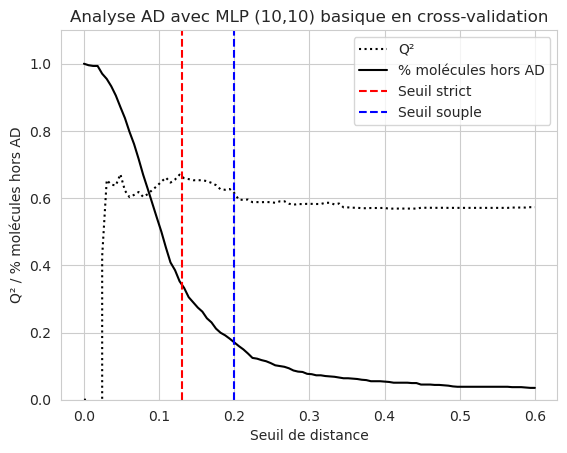

In [10]:
qu.AD_graph(thresholds, q2, pct_out, 0.13, 0.2, "Analyse AD avec MLP (10,10) basique en cross-validation")

On peut voir que le % de molécules excluses du modèle par rapport aux 6 voisins les plus proches diminue au fil de l'augmentation du seuil. Les performances du modèles Q^2 admet un maximim entre 0.1 et 0.2 de seuil. Le seuil strict permettrait d'avoir les meilleures performances et le doux permettrait d'en avoir de moins bonnes mais ils correspondraient à plus de molécule.

On peut donner l'opportunité d'utiliser le seuil strict, doux ou alors le désactiver complétement

### **Optimisation des hyperparamètres**

##### Recherche de la meilleure réprésentation avec la structure neuronale
**/!\\** Attention ceci est extrêmement gourmand est ressources. Ceci a pris une demid journée sur le serveur avec la parallélisation du serveur.

In [ ]:
total_neurones = nb_total_neuron=[10, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
couches = range(1, 11)
qu.generate_configurations(total_neurones, couches, "configurations.txt")

for i, T in enumerate(total_neurones):
    list_of_tuples = qu.load_neural_configuration(f"configurations_{T}.txt")
    # définit les ensembles de paramètres à tester
    param_distributions = {
        'hidden_layer_sizes': list_of_tuples,
        'activation': ['relu', 'tanh'],
        'alpha': loguniform(1e-5, 1e-1),
        'learning_rate_init': loguniform(1e-5, 1e-1)
    }
    qu.run_nested_cv_MLP(df_norm, LC50, param_distributions, f"MLP_{T}", threshold_strict=0.13, threshold_soft=0.2)

#### **Analyse de l'optimisation**

- Rasssemblement des fichiers CSV par configuration en 1 seul

In [4]:
# 2. Définir une fonction pour parser la colonne 'best_params'
def parse_best_params(params_str):
    """
    Nettoie et convertit la chaîne de caractères des paramètres en un dictionnaire Python.
    Remplace 'np.float64(x)' par 'x' pour faciliter la conversion.
    """
    # Remplace 'np.float64(x)' par 'x'
    params_str = re.sub(r'np\.float64\(([^)]+)\)', r'\1', params_str)
    
    # Converti la str en dictionnaire
    try:
        params = ast.literal_eval(params_str)
    except ValueError as e:
        print(f"Erreur de parsing pour la chaîne: {params_str}")
        params = {}
    return params

liste_datframe = []
for csv_files in (os.listdir("nested_MLP_2")):
    if csv_files.endswith(".csv") and csv_files != "nestedCV_MLP_final.csv":
        df = pd.read_csv(f'nested_MLP_2/{csv_files}')  # Remplacez par le chemin de votre fichier

        # Applique la fonction de parsing et créer de nouvelles colonnes
        df_params = df['best_params'].apply(parse_best_params).apply(pd.Series)

        # Fusionne les nouvelles colonnes au DataFrame original
        df = pd.concat([df, df_params], axis=1)
        # faire la somme de chaque tuple
        df["nb_neurones"] = df["hidden_layer_sizes"].apply(lambda x: sum(x))

        # Optionnel : Supprimer la colonne 'best_params' si elle n'est plus nécessaire
        df.drop('best_params', axis=1, inplace=True)
        liste_datframe.append(df)

df_final = pd.concat(liste_datframe)
# colonne avec la moyenne de innerCv_score, r2_noAD, r2_StrictAD, r2_SoftAD
df_final["global_mean_score"] = df_final[["best_score_innerCV", "r2_noAD", "r2_strict", "r2_soft"]].mean(axis=1)
df_final["global_std_score"] = df_final[["best_score_innerCV", "r2_noAD", "r2_strict", "r2_soft"]].std(axis=1)
df_final.to_csv("nested_MLP_2/nestedCV_MLP_final.csv", index=False)

- Score moyen selon le nombre de neurones

In [5]:
grouped = df_final.groupby("nb_neurones").agg({
    "best_score_innerCV": ["mean", "std"],
    "r2_noAD": ["mean", "std"],
    "r2_strict": ["mean", "std"],
    "r2_soft": ["mean", "std"],
})
grouped.columns = ['_'.join(col) for col in grouped.columns]
grouped.reset_index(inplace=True)

grouped

,nb_neurones,best_score_innerCV_mean,best_score_innerCV_std,r2_noAD_mean,r2_noAD_std,r2_strict_mean,r2_strict_std,r2_soft_mean,r2_soft_std
0,10,0.589447,0.033057,0.550233,0.178411,0.662888,0.081501,0.628919,0.075503
1,50,0.592261,0.027619,0.566114,0.181985,0.658627,0.089140,0.634394,0.084503
2,100,0.596700,0.027040,0.551879,0.181756,0.648363,0.070022,0.625931,0.082017
3,200,0.596516,0.027112,0.566018,0.173558,0.694252,0.070924,0.654583,0.069699
4,500,0.611292,0.031855,0.588979,0.171932,0.685746,0.074973,0.656773,0.080138
5,1000,0.602076,0.027532,0.569362,0.160862,0.675930,0.068482,0.648671,0.070381
6,2000,0.589659,0.029691,0.520008,0.165171,0.665320,0.103900,0.621199,0.082683
7,5000,0.583651,0.024958,0.531273,0.194314,0.654580,0.064041,0.610065,0.074039
8,10000,0.584561,0.025711,0.505134,0.153865,0.652914,0.087733,0.609512,0.056006


- Barplot des performances
Cross-validation interne

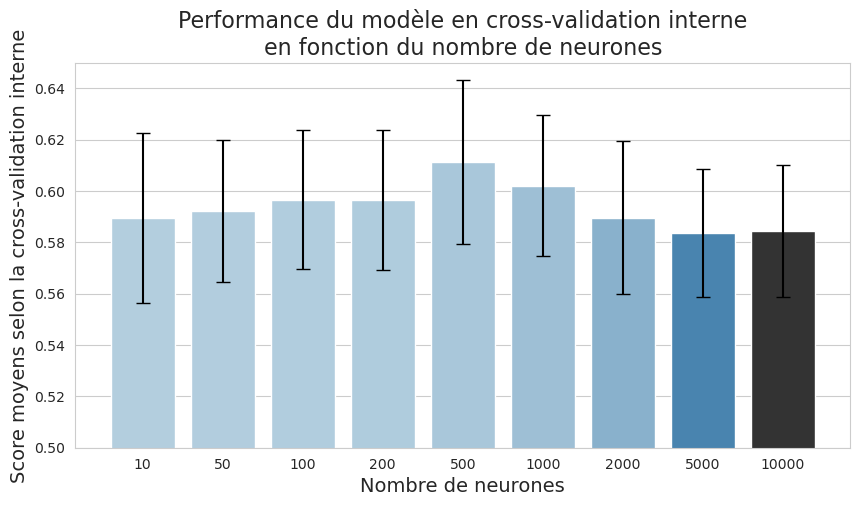

In [7]:
qu.barplot_perf(grouped, 
                "nb_neurones", 
                "best_score_innerCV_mean", 
                "best_score_innerCV_std", 
                "Nombre de neurones",
                "Score moyens selon la cross-validation interne",
                "Performance du modèle en cross-validation interne\nen fonction du nombre de neurones",
                ylim = (0.5, 0.65))

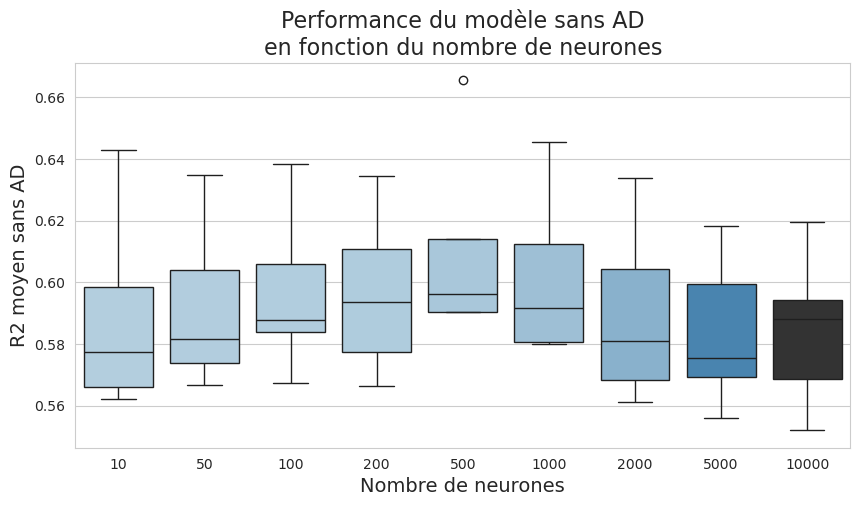

In [8]:
qu.boxplot_perf(df_final, 
                "nb_neurones", 
                "best_score_innerCV",  
                "Nombre de neurones",
                "R2 moyen sans AD",
                "Performance du modèle sans AD\nen fonction du nombre de neurones")

Tous les modèles ont sensiblement le même score, mais le MLP à 500 neurones semblent se démarquer.

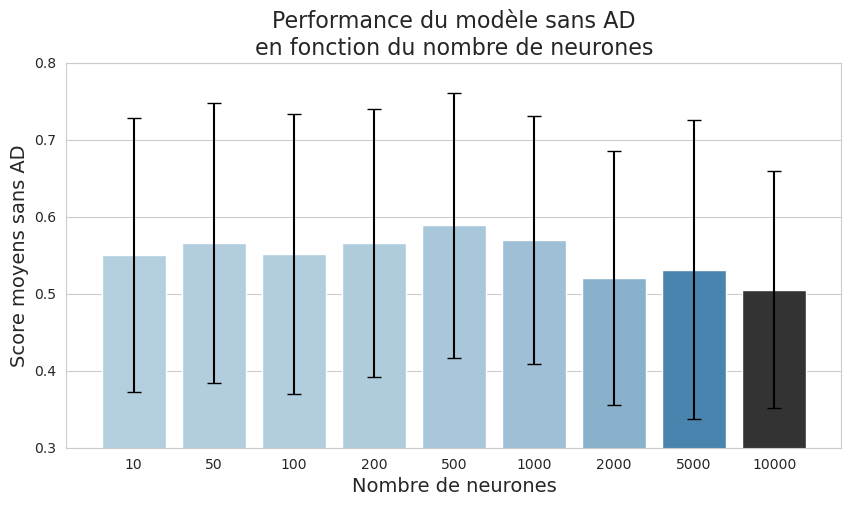

In [12]:
qu.barplot_perf(grouped, 
                "nb_neurones", 
                "r2_noAD_mean", 
                "r2_noAD_std", 
                "Nombre de neurones",
                "Score moyens sans AD",
                "Performance du modèle sans AD\nen fonction du nombre de neurones",
                ylim=(0.3, 0.8))



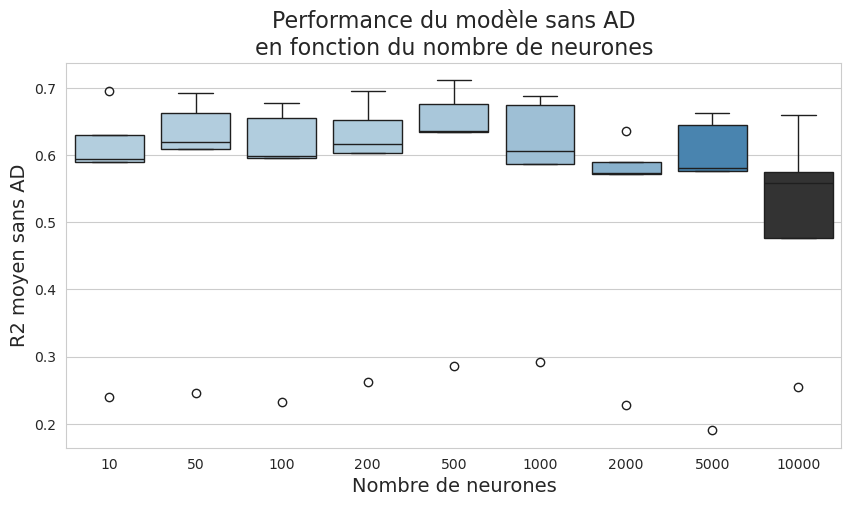

In [13]:
qu.boxplot_perf(df_final,
                "nb_neurones",
                "r2_noAD",
                "Nombre de neurones",
                "R2 moyen sans AD",
                "Performance du modèle sans AD\nen fonction du nombre de neurones")

La configuration à 500 neurones est toujours la meilleure mais celles à 10 et 50 sont sensiblement au même stade. Cependant, leurs écarts-types est plus important, donc leurs performances peuvent plus varier.

De plus, le modèle à 10 000 neurones est le moins bon sur la cross-validation externes. Cela peut sous-entendre un surapprentissage sur les données assez éloignées des molécules d'entrainement

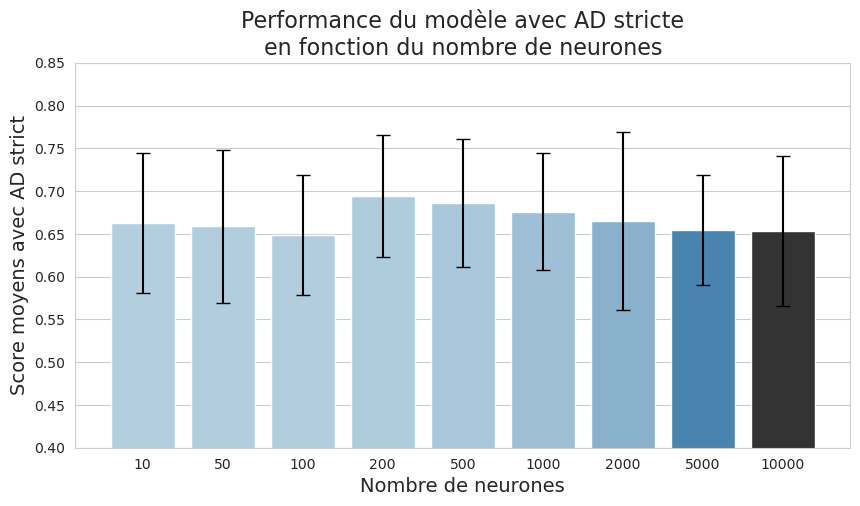

In [14]:
qu.barplot_perf(grouped, 
                "nb_neurones", 
                "r2_strict_mean", 
                "r2_strict_std", 
                "Nombre de neurones",
                "Score moyens avec AD strict",
                "Performance du modèle avec AD stricte\nen fonction du nombre de neurones",
                ylim=(0.4, 0.85))

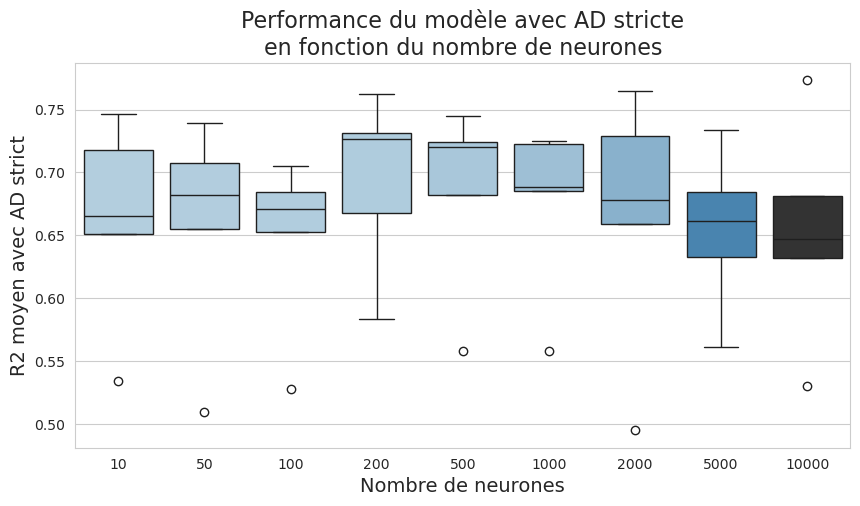

In [15]:
qu.boxplot_perf(df_final,
                "nb_neurones",
                "r2_strict",
                "Nombre de neurones",
                "R2 moyen avec AD strict",
                "Performance du modèle avec AD stricte\nen fonction du nombre de neurones")

Avec l'application du seuil strict pour le domaine d'applicabilité, les performances sur la cross-validation externe sont meilleures (environ +0.1) et tous les modèles ont des performances assez semblables. 

Le modèle à 10 000  neurones performent mieux avec des données proches des données d'apprentissage, ce qui peut renforcer l'idée du surapprentissage. Les modèles à 500 et 100 neurones sont assez similaires mais encore une fois l'écart type de 100 neurones est un peu plus élévé

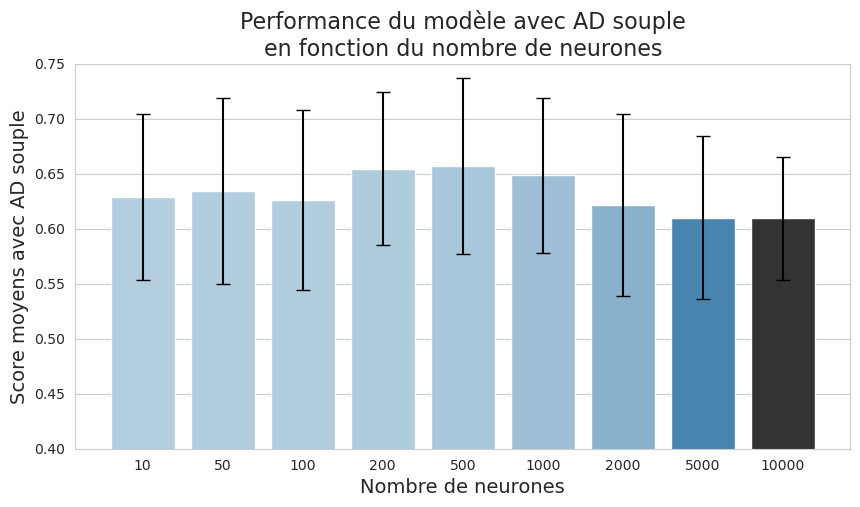

In [16]:
qu.barplot_perf(grouped, 
                "nb_neurones", 
                "r2_soft_mean", 
                "r2_soft_std", 
                "Nombre de neurones",
                "Score moyens avec AD souple",
                "Performance du modèle avec AD souple\nen fonction du nombre de neurones",
                ylim=(0.4, 0.75))

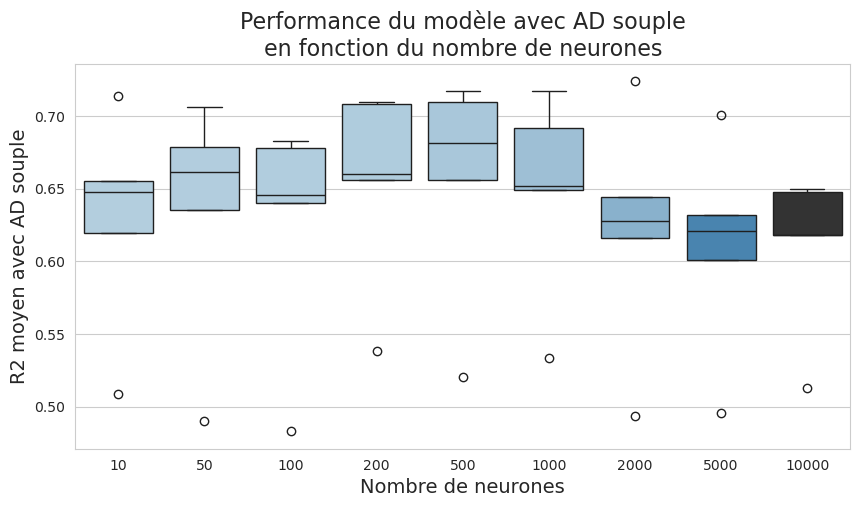

In [17]:
qu.boxplot_perf(df_final,
                "nb_neurones",
                "r2_soft",
                "Nombre de neurones",
                "R2 moyen avec AD souple",
                "Performance du modèle avec AD souple\nen fonction du nombre de neurones")

Rien de nouveau, mise à part que le seuil doux donne des perfs moins bonnes mais c'était attendu

##### **Conclusion sur le nombre de neurones**

- Le modèle à 500 neurones semblent être le plus constant et performant dans tous les cas (en général)
- Les modèles à 10, 50 et 100 sont de bons candidats aussi pour des cas spécifiques
- 1000, 2000, 5000, et 10000 ne sont pas assez souples pour s'adapter aux données de test en général

#### **Etude des hyperparamètres**

In [20]:

grouped_params = df_final.groupby(
    ["nb_neurones","activation", "alpha", "hidden_layer_sizes", "learning_rate_init"]).agg({
    "global_mean_score": ["mean"],
    "global_std_score": ["mean"],
    "best_score_innerCV": ["mean", "std", "count"],
    "r2_noAD": ["mean"],
    "r2_strict": ["mean"],
    "r2_soft": ["mean"]
}).sort_values(
    ("global_mean_score", "mean"), ascending=False
)
grouped_params.to_csv("nested_MLP_2/best_models.csv")
grouped_params.head(10)

global_mean_score  \
                                                                                                                   mean   
nb_neurones activation alpha    hidden_layer_sizes                                 learning_rate_init                     
200         relu       0.036999 (100, 100)                                         0.000251                    0.675813   
                       0.072867 (100, 100)                                         0.000348                    0.670051   
50          relu       0.000018 (8, 7, 7, 7, 7, 7, 7)                              0.004735                    0.668381   
5000        relu       0.000076 (500, 500, 500, 500, 500, 500, 500, 500, 500, 500) 0.001118                    0.668172   
500         relu       0.004054 (56, 56, 56, 56, 56, 55, 55, 55, 55)               0.000051                    0.662548   
1000        relu       0.000542 (100, 100, 100, 100, 100, 100, 100, 100, 100, 100) 0.000021                    0.657940   
100         relu       0.006721 (34, 33, 33)                                       0.014478                    0.651356   
200         tanh       0.000502 (34, 34, 33, 33, 33, 33)                           0.001538                    0.650923   
50          relu       0.000076 (5, 5, 5, 5, 5, 5, 5, 5, 5, 5)                     0.001118                    0.650392   
100         relu       0.000016 (10, 10, 10, 10, 10, 10, 10, 10, 10, 10)           0.000265                    0.649503   

                                                                                                      global_std_score  \
                                                                                                                  mean   
nb_neurones activation alpha    hidden_layer_sizes                                 learning_rate_init                    
200         relu       0.036999 (100, 100)                                         0.000251                   0.074391   
                       0.072867 (100, 100)                                         0.000348                   0.060052   
50          relu       0.000018 (8, 7, 7, 7, 7, 7, 7)                              0.004735                   0.068021   
5000        relu       0.000076 (500, 500, 500, 500, 500, 500, 500, 500, 500, 500) 0.001118                   0.068216   
500         relu       0.004054 (56, 56, 56, 56, 56, 55, 55, 55, 55)               0.000051                   0.043876   
1000        relu       0.000542 (100, 100, 100, 100, 100, 100, 100, 100, 100, 100) 0.000021                   0.049046   
100         relu       0.006721 (34, 33, 33)                                       0.014478                   0.044245   
200         tanh       0.000502 (34, 34, 33, 33, 33, 33)                           0.001538                   0.082144   
50          relu       0.000076 (5, 5, 5, 5, 5, 5, 5, 5, 5, 5)                     0.001118                   0.067583   
100         relu       0.000016 (10, 10, 10, 10, 10, 10, 10, 10, 10, 10)           0.000265                   0.054973   

                                                                                                      best_score_innerCV  \
                                                                                                                    mean   
nb_neurones activation alpha    hidden_layer_sizes                                 learning_rate_init                      
200         relu       0.036999 (100, 100)                                         0.000251                     0.566400   
                       0.072867 (100, 100)                                         0.000348                     0.593610   
50          relu       0.000018 (8, 7, 7, 7, 7, 7, 7)                              0.004735                     0.566812   
5000        relu       0.000076 (500, 500, 500, 500, 500, 500, 500, 500, 500, 500) 0.001118                     0.575416   
500         relu       0.004054 (56, 56, 56, 56

On a les 10 meilleurs modèles selon la moyenne du score de cross validation interne, de la cross validatione externe sans filtre et avec filtre strict et souple

- Visualisation des hyperparamètres

In [19]:
df_param = df_final[["nb_neurones", "alpha", "learning_rate_init", "activation", "hidden_layer_sizes"]]
df_param.sort_values("nb_neurones")

,nb_neurones,alpha,learning_rate_init,activation,hidden_layer_sizes
0,10,0.001876,0.003510,tanh,"(4, 3, 3)"
3,10,0.001876,0.003510,tanh,"(4, 3, 3)"
2,10,0.001876,0.003510,tanh,"(4, 3, 3)"
1,10,0.000761,0.003421,tanh,"(5, 5)"
4,10,0.001162,0.015162,tanh,"(4, 3, 3)"
0,50,0.000018,0.004735,relu,"(8, 7, 7, 7, 7, 7, 7)"
2,50,0.000010,0.002951,tanh,"(10, 10, 10, 10, 10)"
1,50,0.000020,0.000494,relu,"(8, 7, 7, 7, 7, 7, 7)"
4,50,0.000020,0.004021,relu,"(8, 7, 7, 7, 7, 7, 7)"
3,50,0.000076,0.001118,relu,"(5, 5, 5, 5, 5, 5, 5, 5, 5, 5)"
